In [2]:
import trimesh
import torch
import mcubes
import numpy as np
from skgstat import Variogram
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import pdist, squareform

device = 'cuda'
pth_file = 'experiments/suzanne/set100/models/M0.pth'
# pth_file = "experiments/test/set30/models/M0.pth"
nerf_model = torch.load(pth_file).to(device)

# Generate the grid of points for XYZ
N = 35
scale = 1.5
x = torch.linspace(-scale, scale, N, device=device)
y = torch.linspace(-scale, scale, N, device=device)
z = torch.linspace(-scale, scale, N, device=device)
x, y, z = torch.meshgrid((x, y, z))
xyz = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)), dim=1)  # [125000, 3] points

# Define a view direction for color queries (e.g., along the z-axis)
view_direction = torch.tensor([0, 0, 1], device=device).expand(xyz.shape[0], -1)

# Query the NeRF model for colors (assumes `forward` outputs RGB and density)
rgb, _ = nerf_model.forward(xyz, view_direction)  # [125000, 3]

# Convert to numpy for processing
xyz = xyz.cpu().detach().numpy()
rgb = rgb.cpu().detach().numpy()

# Apply masking to reduce the number of points
threshold_value = np.quantile(rgb.mean(axis=1), 0.5)  # Use median RGB intensity as threshold
mask = rgb.mean(axis=1) >= threshold_value  # Mask based only on RGB intensity

# Filter points and colors using the mask
filtered_xyz = xyz[mask]
filtered_rgb = rgb[mask]

/tmp/ipykernel_360157/3853279021.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nerf_model = torch.load(pth_file).to(device)
/home/eherrin@ad.ufl.edu/anaconda3/envs/ne

ANOVA Results - F-statistic: 388.00406679098313, p-value: 0.0
The mean RGB values vary significantly across spatial regions (reject H0).


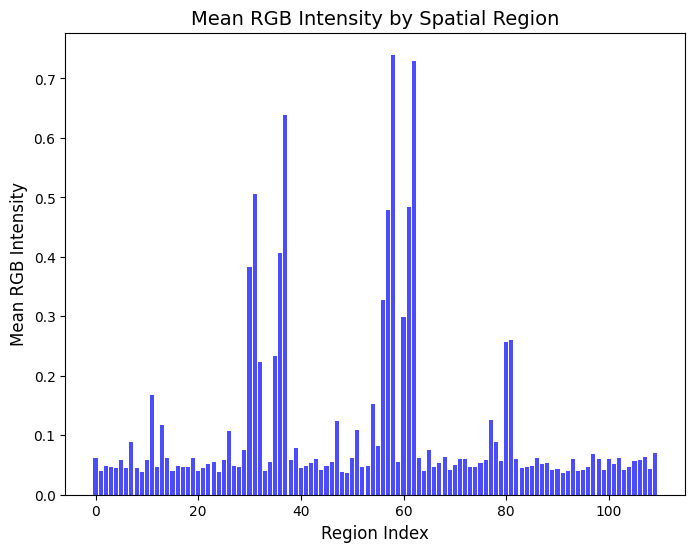

In [3]:
from scipy.stats import f_oneway, kruskal
import numpy as np
import matplotlib.pyplot as plt

# Binning the points into spatial regions
num_bins = 4  # Adjust number of bins as needed
bins_x = np.linspace(filtered_xyz[:, 0].min(), filtered_xyz[:, 0].max(), num_bins + 1)
bins_y = np.linspace(filtered_xyz[:, 1].min(), filtered_xyz[:, 1].max(), num_bins + 1)
bins_z = np.linspace(filtered_xyz[:, 2].min(), filtered_xyz[:, 2].max(), num_bins + 1)

# Assign points to bins
indices_x = np.digitize(filtered_xyz[:, 0], bins_x) - 1
indices_y = np.digitize(filtered_xyz[:, 1], bins_y) - 1
indices_z = np.digitize(filtered_xyz[:, 2], bins_z) - 1

# Group points by bins
bin_groups = {}
for i, (ix, iy, iz) in enumerate(zip(indices_x, indices_y, indices_z)):
    bin_key = (ix, iy, iz)
    if bin_key not in bin_groups:
        bin_groups[bin_key] = []
    bin_groups[bin_key].append(filtered_rgb[i].mean())  # Mean RGB intensity for each point

# Collect mean RGB intensities for each bin
group_means = [np.mean(values) for values in bin_groups.values() if len(values) > 1]

# Perform ANOVA
if len(group_means) > 1:
    f_stat, p_value = f_oneway(*[bin_groups[key] for key in bin_groups.keys()])
    print(f"ANOVA Results - F-statistic: {f_stat}, p-value: {p_value}")

    if p_value < 0.05:
        print("The mean RGB values vary significantly across spatial regions (reject H0).")
    else:
        print("The mean RGB values are consistent across spatial regions (fail to reject H0).")

# Visualization of regional means
plt.figure(figsize=(8, 6))
plt.bar(range(len(group_means)), group_means, color='blue', alpha=0.7)
plt.xlabel("Region Index", fontsize=12)
plt.ylabel("Mean RGB Intensity", fontsize=12)
plt.title("Mean RGB Intensity by Spatial Region", fontsize=14)
plt.show()


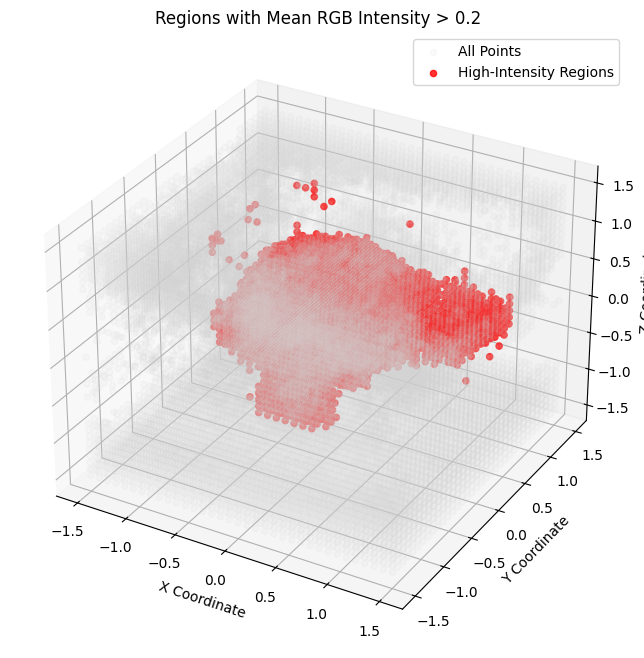

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for mean RGB intensity
mean_rgb_threshold = 0.2  # Adjust this based on your data

# Identify regions with mean RGB intensity above the threshold
high_intensity_regions = [key for key, values in bin_groups.items() if np.mean(values) > mean_rgb_threshold]

# Extract points corresponding to high-intensity regions
high_intensity_points = []
for ix, iy, iz in high_intensity_regions:
    # Find points in these bins
    mask = (
        (indices_x == ix) &
        (indices_y == iy) &
        (indices_z == iz)
    )
    high_intensity_points.append(filtered_xyz[mask])

# Flatten the list of points
high_intensity_points = np.vstack(high_intensity_points)

# Plot the high-intensity points in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all points in light grey for context
ax.scatter(filtered_xyz[:, 0], filtered_xyz[:, 1], filtered_xyz[:, 2], c='lightgrey', alpha=0.1, label='All Points')

# Highlight the high-intensity points in red
ax.scatter(
    high_intensity_points[:, 0], high_intensity_points[:, 1], high_intensity_points[:, 2],
    c='red', alpha=0.8, label='High-Intensity Regions'
)

# Add labels and legend
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title(f'Regions with Mean RGB Intensity > {mean_rgb_threshold}')
ax.legend()
plt.show()
